In [1]:
!pip install tensorflow

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


In [2]:
!pip install gpflow

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


In [3]:
import datetime
import io
import matplotlib.pyplot as plt

import numpy as np
import tensorflow as tf
import gpflow as gpf

from gpflow.utilities import print_summary
from gpflow.ci_utils import ci_niter

In [12]:
gpf.config.set_default_float(np.float64)
gpf.config.set_default_summary_fmt("notebook")
np.random.seed(0)
%matplotlib inline

MAXITER = ci_niter(2000)

In [13]:
N = 100  # number of points
D = 1  # number of input dimensions
M = 15  # number of inducing points
L = 2  # number of latent GPs
P = 3  # number of observations = output dimensions

In [14]:
def generate_data(N):
    X = np.random.rand(N)[:, None] * 10 - 5 # inputs = N x D
    G = np.hstack((0.5 * np.sin(3 * X) + X, 3.0 * np.cos(X) - X))  # G = NxL
    W = np.array([[0.5, -0.3, 1.5], [-0.4, 0.43, 0.0]])  # L x P
    F = np.matmul(G, W)  # N x P
    Y = F + np.random.randn(*F.shape) * [0.2, 0.2, 0.2]
    return X, Y

In [15]:
X, Y = data = generate_data(N)

In [16]:
Zinit = np.linspace(-5, 5, M)[:, None]

In [30]:
def plot_model(m, lower=-8.0, upper=8.0):
    pX = np.linspace(lower, upper, 100)[:, None]
    pY, pYv = m.predict_y(pX)
    if pY.ndim == 3:
        pY = pY[:, 0, :]
    plt.plot(X, Y, "x")
    plt.gca().set_prop_cycle(None)
    plt.plot(pX, pY)
    for i in range(pY.shape[1]):
        top = pY[:, i] + 2.0 * pYv[:, i] ** 0.5
        bot = pY[:, i] - 2.0 * pYv[:, i] ** 0.5
        plt.fill_between(pX[:, 0], top, bot, alpha=0.3)
    plt.xlabel("X")
    plt.ylabel("f")
    plt.title(f"ELBO: {m.elbo(data):.3}")
    plt.plot(Z, Z * 0.0, "o")

In [22]:
kernel = gpf.kernels.SharedIndependent(
    gpf.kernels.SquaredExponential() + gpf.kernels.Linear(), output_dim=P
)
Z = Zinit.copy()
iv = gpf.inducing_variables.SharedIndependentInducingVariables(
    gpf.inducing_variables.InducingPoints(Z)
)

In [24]:
m = gpf.models.SVGP(kernel, gpf.likelihoods.Gaussian(), inducing_variable=iv, num_latent_gps=P)
print_summary(m)

name,class,transform,prior,trainable,shape,dtype,value
SVGP.kernel.kernel.kernels[0].variance,Parameter,Softplus,,True,(),float64,0.9999999999999999
SVGP.kernel.kernel.kernels[0].lengthscales,Parameter,Softplus,,True,(),float64,0.9999999999999999
SVGP.kernel.kernel.kernels[1].variance,Parameter,Softplus,,True,(),float64,0.9999999999999999
SVGP.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,1.0
SVGP.inducing_variable.inducing_variable.Z,Parameter,Identity,,True,"(15, 1)",float64,[[-5....
SVGP.q_mu,Parameter,Identity,,True,"(15, 3)",float64,"[[0., 0., 0...."
SVGP.q_sqrt,Parameter,FillTriangular,,True,"(3, 15, 15)",float64,"[[[1., 0., 0...."


In [25]:
def optimize_model_with_scipy(model):
    optimizer = gpf.optimizers.Scipy()
    optimizer.minimize(
        model.training_loss_closure(data),
        variables=model.trainable_variables,
        method="l-bfgs-b",
        options={"disp": True, "maxiter": MAXITER},
    )
optimize_model_with_scipy(m)

In [26]:
print_summary(m)

name,class,transform,prior,trainable,shape,dtype,value
SVGP.kernel.kernel.kernels[0].variance,Parameter,Softplus,,True,(),float64,0.9271799953949702
SVGP.kernel.kernel.kernels[0].lengthscales,Parameter,Softplus,,True,(),float64,0.7982118437937316
SVGP.kernel.kernel.kernels[1].variance,Parameter,Softplus,,True,(),float64,1.2133630793713974
SVGP.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,0.039662543309073234
SVGP.inducing_variable.inducing_variable.Z,Parameter,Identity,,True,"(15, 1)",float64,[[-4.83948288...
SVGP.q_mu,Parameter,Identity,,True,"(15, 3)",float64,"[[-0.90113514, 0.69864887, -1.47422748..."
SVGP.q_sqrt,Parameter,FillTriangular,,True,"(3, 15, 15)",float64,"[[[1.71138315e-02, 0.00000000e+00, 0.00000000e+00..."


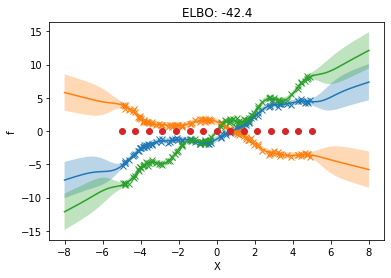

In [31]:
plot_model(m)

In [29]:
print_summary(m.kernel)
m.kernel.kernel.kernels[0].lengthscales

name,class,transform,prior,trainable,shape,dtype,value
SharedIndependent.kernel.kernels[0].variance,Parameter,Softplus,,True,(),float64,0.92718
SharedIndependent.kernel.kernels[0].lengthscales,Parameter,Softplus,,True,(),float64,0.798212
SharedIndependent.kernel.kernels[1].variance,Parameter,Softplus,,True,(),float64,1.21336


<Parameter: name=softplus, dtype=float64, shape=[], fn="softplus", numpy=0.7982118437937316>

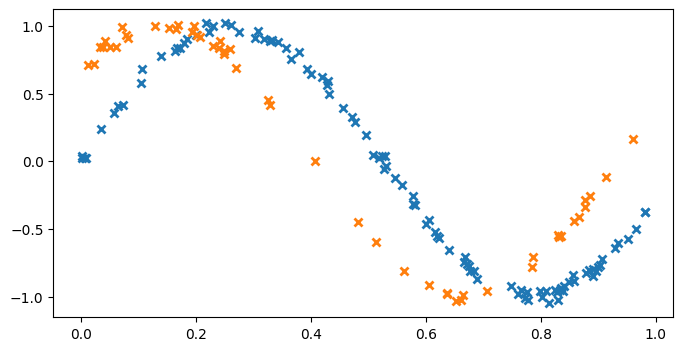

In [7]:
x1 = np.random.rand(100, 1)
x2 = np.random.rand(50, 1)

y1 = np.sin(6*x1) + np.random.randn(*x1.shape) * 0.03
y2 = np.sin(6*x2 + 0.7) + np.random.randn(*x2.shape) * 0.03

plt.figure(figsize=(8, 4))
plt.plot(x1, y1, 'x', mew=2)
plt.plot(x2, y2, 'x', mew=2)

In [8]:
x_augmented = np.vstack((np.hstack((x1, np.zeros_like(x1))), np.hstack((x2, np.ones_like(x2)))))
y_augmented = np.vstack((np.hstack((y1, np.zeros_like(y1))), np.hstack((y2, np.ones_like(y2)))))

In [12]:
output_dim = 2
rank = 1
k1 = gpf.kernels.Matern32(1, active_dims=[0])
coreg = gpf.kernels.Coregion(output_dim=output_dim, rank=rank, active_dims=[1])
coreg.W = np.random.rand(output_dim, rank)
kern = k1 * coreg

In [30]:
output_dim = 2
rank = 1
kern = gpf.kernels.SharedIndependent(
    gpf.kernels.Matern32(1, active_dims=[0]) * gpf.kernels.Coregion(output_dim=output_dim, rank=rank, active_dims=[1]) + gpf.kernels.White(x_augmented), output_dim=output_dim
)

InvalidArgumentError: {{function_node __wrapped__CheckNumerics_device_/job:localhost/replica:0/task:0/device:GPU:0}} gpflow.Parameter: the value to be assigned is incompatible with this parameter's transform (the corresponding unconstrained value has NaN or Inf) and hence cannot be assigned. : Tensor had Inf values [Op:CheckNumerics]

In [18]:
lik = gpf.likelihoods.SwitchedLikelihood([gpf.likelihoods.Gaussian(), gpf.likelihoods.Gaussian()])
m = gpf.models.VGP([x_augmented, y_augmented], kernel=kern, likelihood=lik, num_latent_gps=1)

In [24]:
def optimize_model_with_scipy(model):
    optimizer = gpf.optimizers.Scipy()
    optimizer.minimize(
        model.training_loss,
        variables=model.trainable_variables,
        method="l-bfgs-b",
        options={"disp": True, "maxiter": 1000},
    )
optimize_model_with_scipy(m)

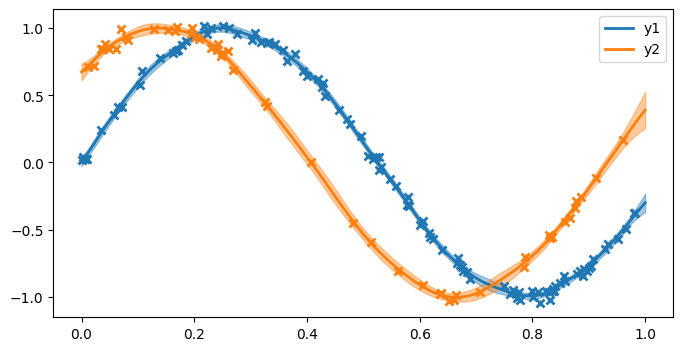

In [25]:
def plot_gp(x, mu, var, color, label):
    plt.plot(x, mu, color=color, lw=2, label=label)
    plt.fill_between(x[:, 0],
                     (mu - 2*np.sqrt(var))[:, 0],
                     (mu + 2*np.sqrt(var))[:, 0],
                     color=color, alpha=0.4)

def plot(m):
    plt.figure(figsize=(8, 4))
    xtest = np.linspace(0, 1, 100)[:,None]
    line, = plt.plot(x1, y1, 'x', mew=2)
    mu, var = m.predict_f(np.hstack((xtest, np.zeros_like(xtest))))
    plot_gp(xtest, mu, var, line.get_color(), 'y1')

    line, = plt.plot(x2, y2, 'x', mew=2)
    mu, var = m.predict_f(np.hstack((xtest, np.ones_like(xtest))))
    plot_gp(xtest, mu, var, line.get_color(), 'y2')

    plt.legend()

plot(m)

In [28]:
optimizer = gpf.optimizers.Adam()

AttributeError: module 'gpflow.optimizers' has no attribute 'Adam'

In [27]:
optimizer